# Team 1 CS 105 Final Project Data Processing and Analysis

### Data Preparation
Now, let's process our files.

In [16]:
import os
import numpy as np

import codecs
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings('ignore')

neg_dir = 'Project Datasets/neg'
pos_dir = 'Project Datasets/pos'

indices = []
train = []

for file in os.listdir(os.path.join(os.getcwd(), neg_dir)):
    f = os.path.join(os.getcwd(), neg_dir, file)
    text_input = codecs.open(f, 'r', encoding='utf-8', errors='ignore')
    text = text_input.read()
    train.append(text)
    indices.append(file[:-4])
    text_input.close()

for file in os.listdir(os.path.join(os.getcwd(), pos_dir)):
    f = os.path.join(os.getcwd(), pos_dir, file)
    text_input = codecs.open(f, 'r', encoding='utf-8', errors='ignore')
    text = text_input.read()
    train.append(text)
    indices.append(file[:-4])
    text_input.close()

### Exploratory Data Analysis
We can look at the word frequencies for positive and negative reviews to see what the most common words in each are. We will do this by summing the frequency of each word across all postive documents, and then do the same for the frequencies in all negative documents.

In [20]:
# TF Vectorizor
# Don't indlude stop words in vocabulary
# Only include tokens that appear in at least 10 documents
# Remove strictly numeric tokens
from sklearn.feature_extraction.text import CountVectorizer

tfvectorizer = CountVectorizer(analyzer='word',stop_words='english', min_df=10,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

tf_word_matrix = tfvectorizer.fit_transform(train)
tf_tokens = tfvectorizer.get_feature_names()

df_tf = pd.DataFrame(data = tf_word_matrix.toarray(), index = indices, columns = tf_tokens)

# Labelling data
df_tf['LABEL'] = 'Negative'
df_tf.iloc[2500:,-1] = 'Positive'

df_tf

,13th,1930s,1940s,1950s,1960s,1970s,1980s,1990s,19th,1st,...,youngest,youth,youthful,youtube,z,zero,zombie,zombies,zone,LABEL
10003_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
10007_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
10009_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
10010_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
10012_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
9976_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
9979_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
9988_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive


br            10374
s              6299
movie          4898
t              4225
film           3983
like           2243
just           2125
bad            1480
good           1448
time           1237
really         1198
don            1117
story          1100
people          946
make            930
plot            861
acting          857
way             805
movies          805
characters      764
dtype: object


<AxesSubplot:>

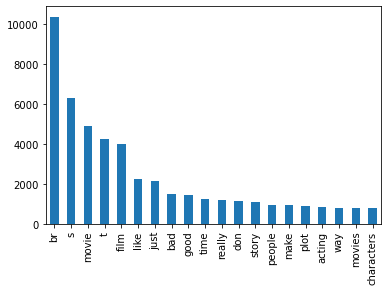

In [21]:
negative_tf = df_tf.head(2500)
negativeFrequencyVector = negative_tf.sum()
negativeFrequencyVector.drop(index=negativeFrequencyVector.index[-1], axis=0, inplace=True)

negativeFrequencyVector = negativeFrequencyVector.sort_values(ascending = False)
first_20_negative = negativeFrequencyVector.head(20)
print(first_20_negative)
first_20_negative.plot.bar()

br            9723
s             6483
film          4045
movie         3765
t             2672
like          1823
good          1512
just          1461
time          1342
story         1299
great         1238
really        1112
best           924
love           896
people         891
way            841
life           837
characters     759
films          747
think          741
dtype: object


<AxesSubplot:>

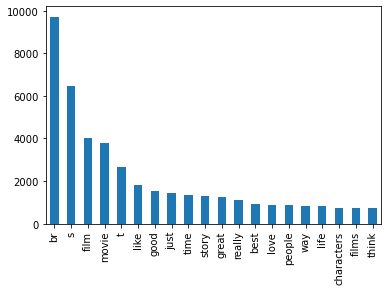

In [22]:
postive_tf = df_tf.tail(2500)
postiveFrequencyVector = postive_tf.sum()
postiveFrequencyVector.drop(index=postiveFrequencyVector.index[-1], axis=0, inplace=True)

postiveFrequencyVector = postiveFrequencyVector.sort_values(ascending = False)
first_20_positive = postiveFrequencyVector.head(20)
print(first_20_positive)
first_20_positive.plot.bar()

Now, let's build the vocabulary for our bag-of-worlds model and vectorize our documents

In [23]:
# Tf-IDF Vectorizor
# Don't indlude stop words in vocabulary
# Only include tokens that appear in at least 10 documents
# Remove strictly numeric tokens
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words='english', min_df=10,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

tfidf_word_matrix = tfidfvectorizer.fit_transform(train)
tfidf_tokens = tfidfvectorizer.get_feature_names()

df_tfidf = pd.DataFrame(data = tfidf_word_matrix.toarray(), index = indices, columns = tfidf_tokens)

# Labelling data
df_tfidf['LABEL'] = 'Negative'
df_tfidf.iloc[2500:,-1] = 'Positive'

df_tfidf

,13th,1930s,1940s,1950s,1960s,1970s,1980s,1990s,19th,1st,...,youngest,youth,youthful,youtube,z,zero,zombie,zombies,zone,LABEL
10003_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10007_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10009_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10010_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10012_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive
9976_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive
9979_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive
9988_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive


br        290.369064
movie     157.815476
s         145.004841
t          122.51203
film      119.378393
bad        78.878523
just       75.765403
like       75.162359
good        58.86915
really     54.253815
don        53.430718
time       50.544036
plot        47.30786
acting     47.207367
story      47.152047
people     44.061594
movies     43.572794
make       42.745059
watch      40.606898
worst      39.615371
dtype: object


<AxesSubplot:>

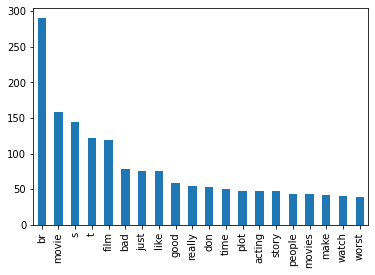

In [9]:
negative_tfidf = df_tfidf.head(2500)
negativeFrequencyVector = negative_tfidf.sum()
negativeFrequencyVector.drop(index=negativeFrequencyVector.index[-1], axis=0, inplace=True)

negativeFrequencyVector = negativeFrequencyVector.sort_values(ascending = False)
first_20_negative = negativeFrequencyVector.head(20)
print(first_20_negative)
first_20_negative.plot.bar()

br        253.854599
s         146.413756
movie     123.494708
film      119.754429
t          76.588532
great      63.330401
like       61.256422
good       59.433059
story      54.660977
just       52.115583
time       51.135203
really     49.484491
best       47.034476
love       46.876035
people      41.11342
life       40.341176
movies     37.487067
think      37.068487
watch      36.912684
way        36.581457
dtype: object


<AxesSubplot:>

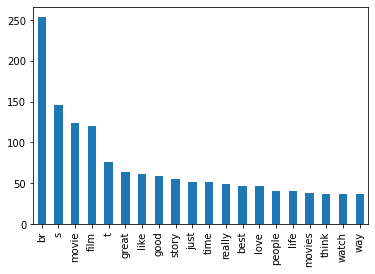

In [24]:
postive_tfidf = df_tfidf.tail(2500)
postiveFrequencyVector = postive_tfidf.sum()
postiveFrequencyVector.drop(index=postiveFrequencyVector.index[-1], axis=0, inplace=True)

postiveFrequencyVector = postiveFrequencyVector.sort_values(ascending = False)
first_20_positive = postiveFrequencyVector.head(20)
print(first_20_positive)
first_20_positive.plot.bar()

Something else that might be interesting would be to visualize the most frequent words used in a negative review versus a positive one. For this, we can use word clouds. The first word cloud shown is for our negative reviews and the second one is for our positive reviews.

When initially making the word clouds, we noticed that there were many shared words between negative and positive reviews. Of course, this is proably due to common words having very high counts. Word cloud doesn't support a normalization function such as idf, so to combat this problem, we set the minimum word length to 9 characters and removed words that would be common to both negative and positive reviews, such as 'something' and 'character'. 

In [17]:
df = pd.DataFrame(train, columns=['review'])
df['label'] = 'Negative'
df.iloc[2500:,-1] = 'Positive'

negative = df['review'][df['label']=='Negative']
positive = df['review'][df['label']=='Positive']

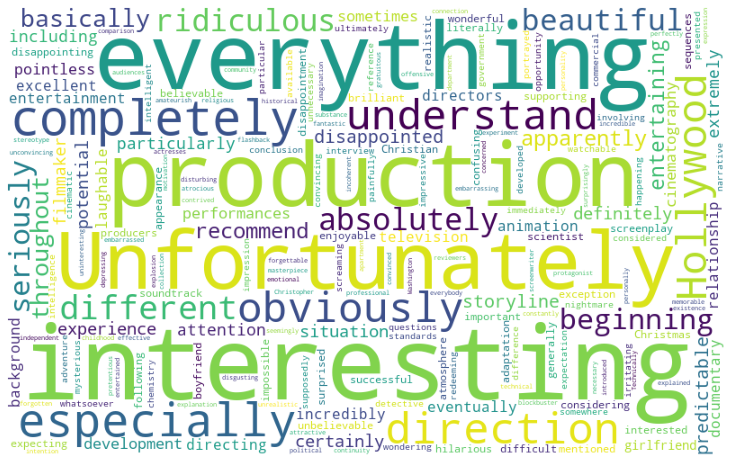

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
stopwords.add('something')
stopwords.add('performance')
stopwords.add('character')
stopwords.add('characters')

negative_wc = WordCloud(width=800,height=500,background_color='white', stopwords=stopwords, min_word_length=9).generate(' '.join(negative))

plt.figure(figsize=(10,8))
plt.imshow(negative_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

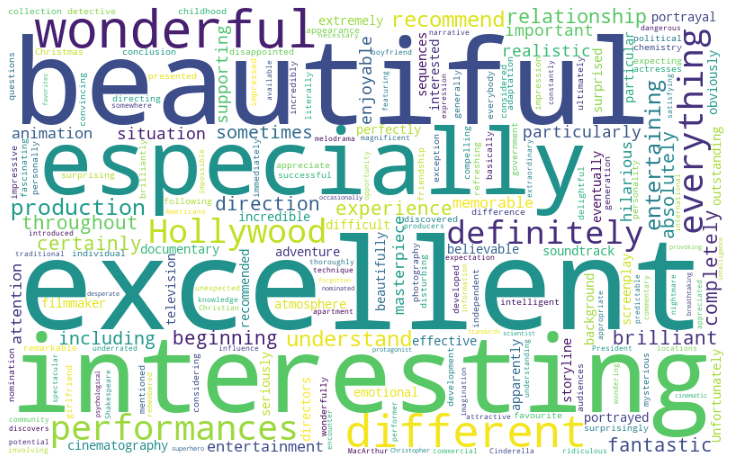

In [19]:
positive_wc = WordCloud(width=800,height=500,background_color='white', stopwords=stopwords, min_word_length=9).generate(' '.join(positive))

plt.figure(figsize=(10,8))
plt.imshow(positive_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Comparison of Classification Models
Now, let's create our train and test sets. We will first look at how Gaussian Naive Bayes performs.

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# Creating Train and Test sets
X = np.array(df_tfidf.drop(['LABEL'], axis=1))
Y = np.array(df_tfidf['LABEL'])

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=123)

naive = GaussianNB()
naive.fit(X_train, Y_train)

Y_pred_NB = naive.predict(X_test)
print('Accuracy using Gaussian Naive Bayes =', accuracy_score(Y_test, Y_pred_NB))
scores = cross_val_score(naive, X_test, Y_test, cv=5)
print(scores)
print("Cross validation produces an average of %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy using Gaussian Naive Bayes = 0.744
[0.57 0.64 0.65 0.63 0.64]
Cross validation produces an average of 0.63 accuracy with a standard deviation of 0.03


In [26]:
# Print Classification Report
print(classification_report(Y_test, Y_pred_NB))

              precision    recall  f1-score   support

    Negative       0.74      0.75      0.75       253
    Positive       0.74      0.73      0.74       247

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



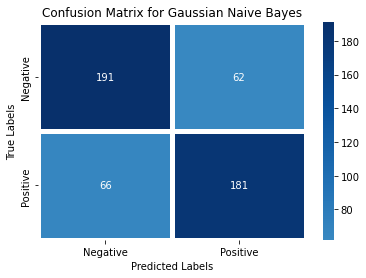

In [27]:
import seaborn as sns

# Plot Confusion matrix heatmap
cf = confusion_matrix(Y_test, Y_pred_NB)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for Gaussian Naive Bayes')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

As you can see from the confusion matrix, from our test set, we correctly classified 183 negative reviews correctly and 178 positive reviews correctly. We incorrectly classified 70 negative reviews as positive and 69 positive reviews as negative. Let's now test how a SVM model will perform using the same train and test sets.

In [37]:
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

clf = XGBClassifier(subsample = 0.7, max_depth = 5)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using XGBoost =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("Cross validation produces an average of %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy using XGBoost = 0.802
[0.71 0.72 0.68 0.67 0.74]
Cross validation produces an average of 0.70 accuracy with a standard deviation of 0.03


In [38]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

    Negative       0.84      0.75      0.79       253
    Positive       0.77      0.85      0.81       247

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500



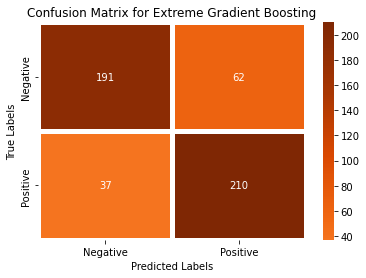

In [40]:
cf = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Oranges", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for Extreme Gradient Boosting')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

In [41]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(splitter="random")
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using Decision Tree =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("Cross validation produces an average of %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy using Decision Tree = 0.71
[0.61 0.64 0.72 0.62 0.68]
Cross validation produces an average of 0.65 accuracy with a standard deviation of 0.04


In [ ]:
print(classification_report(Y_test, Y_pred))

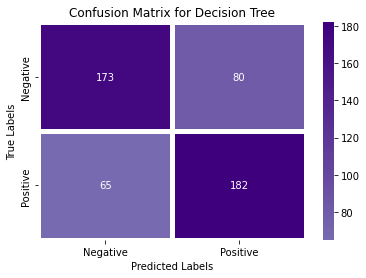

In [42]:
cf = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Purples", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for Decision Tree')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 50)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using Random Forest =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("Cross validation produces an average of %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy using Random Forest = 0.832
[0.76 0.75 0.71 0.71 0.78]
Cross validation produces an average of 0.74 accuracy with a standard deviation of 0.03


In [44]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83       253
    Positive       0.82      0.84      0.83       247

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



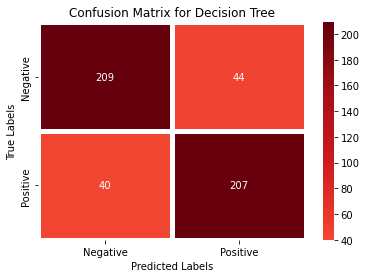

In [47]:
cf = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Reds", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for Decision Tree')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

In [34]:
from sklearn.svm import SVC
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error


clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using SVM =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("Cross validation produces an average of %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


Accuracy using SVM = 0.856
[0.72 0.8  0.74 0.79 0.83]
Cross validation produces an average of 0.78 accuracy with a standard deviation of 0.04


In [35]:
# Print Classification Report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

    Negative       0.88      0.83      0.85       253
    Positive       0.83      0.89      0.86       247

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



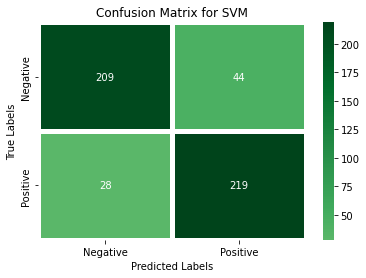

In [36]:
# Plot Confusion matrix heatmap
cf = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Greens", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for SVM')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

As you can see from the confusion matrix, from our test set, we correctly classified 205 negative reviews correctly and 214 positive reviews correctly. We incorrectly classified 48 negative reviews as positive and 33 positive reviews as negative. Our SVM model performs slightly better than Gaussian Naive Bayes, so we will save SVM as our final model.

In [ ]:
import pickle

filename = 'review_classifier.pkl'
f = open(filename, 'wb')
pickle.dump(clf, f)
f.close()